In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, classification_report, 
roc_curve, precision_recall_curve,roc_auc_score,accuracy_score)
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler,SMOTE

import torch
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

### Import raw data

In [3]:
data_path = 'data/df_holdout_scholarjet.csv'
rawdata_test = pd.read_csv(data_path,index_col = 0)
rawdata_train = pd.read_csv('data/df_training_scholarjet.csv',index_col = 0)

### Look at the data shape

In [4]:
rawdata_train.shape,rawdata_test.shape


((28126, 183), (30375, 181))

## We can notices that data is umbanlance

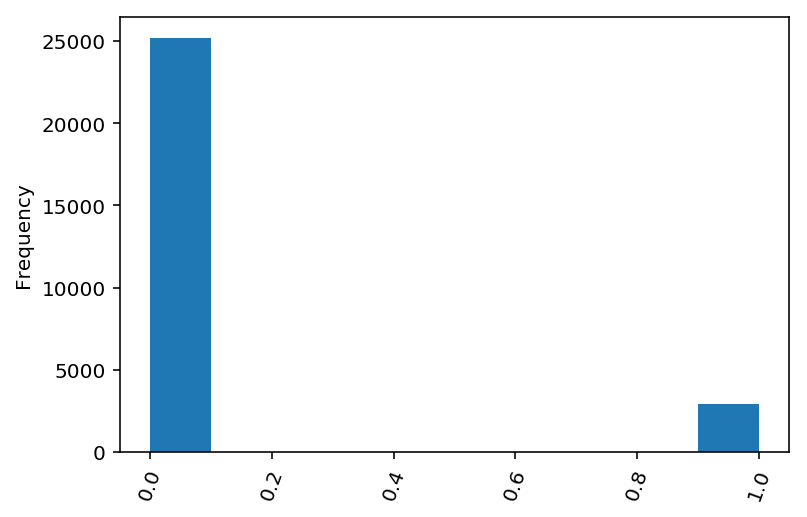

In [5]:
rawdata_train['convert_30'].plot(kind='hist', rot=70,)

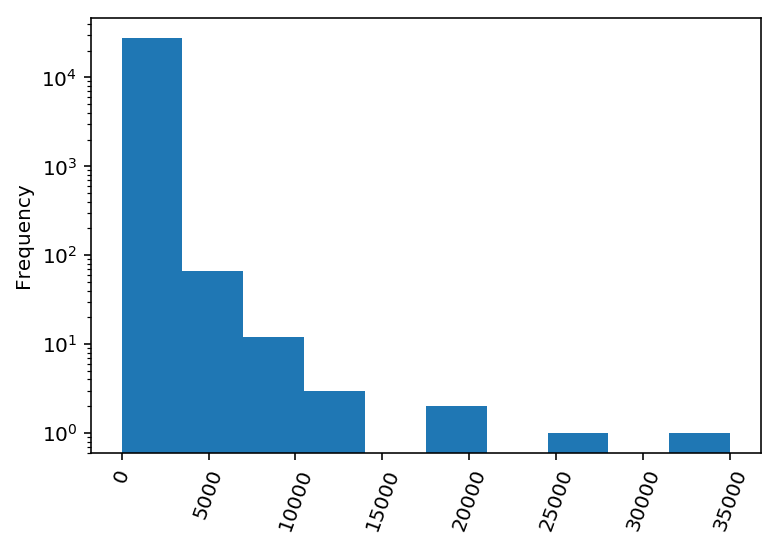

In [6]:
rawdata_train['revenue_30'].plot(kind='hist', rot=70, logy=True)

In [7]:
rawdata_train = rawdata_train.replace('NaN',np.NaN) # making the missing be Nan
rawdata_train.fillna(rawdata_train.mean(), inplace=True) # fill with mean
print(rawdata_train.isnull().sum()) # fianl check

cuid                            0
convert_30                      0
revenue_30                      0
roll_up                         0
currentstatus                   0
companytypegroup                0
team                            0
customersource                  0
accrole                         0
num_employees                   0
num_purchases_year              0
cost_purchases_year             0
enrollmentmethod                0
numorderone                     0
numorderthreeone                0
numorderseventhree              0
numorderthirtyseven             0
numordersixtythirty             0
numorderyearsixty               0
sumrevone                       0
sumrevthreeone                  0
sumrevseventhree                0
sumrevthirtyseven               0
sumrevsixtythirty               0
sumrevyearsixty                 0
numbamorder                     0
numselforder                    0
totalrev                        0
aov                             0
dayssincelasto

## Dummy Variable 

In [8]:
dummy_fields = ['roll_up', 'currentstatus', 'companytypegroup','team','customersource','accrole','num_employees',
                'num_purchases_year','cost_purchases_year','enrollmentmethod']
for i in dummy_fields:
    print(rawdata_train[i].value_counts())
rawdata_train.head()

Unmanaged     14748
Onboarding     9986
Retention      3392
Name: roll_up, dtype: int64
Enrolled       18199
Active          9918
In Progress        8
Unconfirmed        1
Name: currentstatus, dtype: int64
Business    22748
Trade        5378
Name: companytypegroup, dtype: int64
US    25799
CA     2327
Name: team, dtype: int64
Internal Application        10888
Internal Customer Scrape     5849
Social - Paid                3203
External Application         3032
Search - Paid                2113
Affiliates                   1523
Other                         904
Referral                      300
Bulk Upload                   124
Email                         105
Display - Acquisition          27
Quotes                         20
Gateway                        19
Display - Retargeting          14
Self ID                         3
Partners                        2
Name: customersource, dtype: int64
None         14849
Primary      10484
Purchaser     2747
Other           46
Name: accrole, dt

,cuid,convert_30,revenue_30,roll_up,currentstatus,companytypegroup,team,customersource,accrole,num_employees,...,percemailopenedyearsixty,percemailclickedone,percemailclickedthreeone,percemailclickedseventhree,percemailclickedthirtyseven,percemailclickedsixtythirty,percemailclickedyearsixty,currentapplicability,numemaillist,dayssinceenrollment
1,20,0,0.0,Onboarding,Active,Business,US,External Application,None,50plus,...,0.000000,0.0,0.0,0.0,0.190476,0.000000,0.000000,3.000000,1.000000,17
2,57,0,0.0,Onboarding,Active,Business,US,Internal Application,None,2to5,...,0.020000,0.0,0.0,0.0,0.040000,0.000000,0.020000,3.000000,1.000000,70
3,163,0,0.0,Onboarding,Active,Business,US,Internal Application,None,1,...,0.106195,0.0,0.0,0.0,0.000000,0.000000,0.001770,13.000000,1.000000,27
4,167,0,0.0,Onboarding,Enrolled,Business,US,Internal Customer Scrape,None,50plus,...,0.100000,0.0,0.0,0.0,0.000000,0.000000,0.100000,5.087619,1.332081,25
5,168,0,0.0,Onboarding,Enrolled,Business,US,Gateway,None,6to10,...,0.072072,0.0,0.0,0.0,0.009524,0.016807,0.003465,8.333333,3.000000,33


In [9]:
for each in dummy_fields: # dunmy it
    dummies = pd.get_dummies(rawdata_train[each], prefix=each, drop_first=False)
    rawdata_train = pd.concat([rawdata_train, dummies], axis=1)
rawdata_train.shape

(28126, 238)

In [10]:
### Checking it again

In [11]:
rawdata_train.head() # 238 columns

,cuid,convert_30,revenue_30,roll_up,currentstatus,companytypegroup,team,customersource,accrole,num_employees,...,cost_purchases_year_25to100,cost_purchases_year_5to25,cost_purchases_year_None,cost_purchases_year_lessthan1,enrollmentmethod_directEIN,enrollmentmethod_directOther,enrollmentmethod_email,enrollmentmethod_liveTransfer,enrollmentmethod_other,enrollmentmethod_phone
1,20,0,0.0,Onboarding,Active,Business,US,External Application,None,50plus,...,0,0,0,1,1,0,0,0,0,0
2,57,0,0.0,Onboarding,Active,Business,US,Internal Application,None,2to5,...,1,0,0,0,1,0,0,0,0,0
3,163,0,0.0,Onboarding,Active,Business,US,Internal Application,None,1,...,0,0,0,0,1,0,0,0,0,0
4,167,0,0.0,Onboarding,Enrolled,Business,US,Internal Customer Scrape,None,50plus,...,0,0,0,1,1,0,0,0,0,0
5,168,0,0.0,Onboarding,Enrolled,Business,US,Gateway,None,6to10,...,0,1,0,0,1,0,0,0,0,0


### Dropping the original columns

In [12]:
fields_to_drop = ['cuid', 'roll_up', 'currentstatus', 'companytypegroup','team','customersource','accrole','num_employees',
                'num_purchases_year','cost_purchases_year','enrollmentmethod']
data = rawdata_train.drop(fields_to_drop, axis=1)
data.head()# 227 columns

,convert_30,revenue_30,numorderone,numorderthreeone,numorderseventhree,numorderthirtyseven,numordersixtythirty,numorderyearsixty,sumrevone,sumrevthreeone,...,cost_purchases_year_25to100,cost_purchases_year_5to25,cost_purchases_year_None,cost_purchases_year_lessthan1,enrollmentmethod_directEIN,enrollmentmethod_directOther,enrollmentmethod_email,enrollmentmethod_liveTransfer,enrollmentmethod_other,enrollmentmethod_phone
1,0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,1,1,0,0,0,0,0
2,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,1,0,0,0,1,0,0,0,0,0
3,0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,1,0,0,0,0,0
4,0,0.0,0.022367,0.037827,0.078231,0.336425,0.337044,1.323954,10.836336,17.994792,...,0,0,0,1,1,0,0,0,0,0
5,0,0.0,0.022367,0.037827,0.078231,0.336425,0.337044,1.323954,10.836336,17.994792,...,0,1,0,0,1,0,0,0,0,0


In [13]:
data.to_csv('data/dummy_data.csv') #runing this data in model.py

In [14]:
regressiondata = data[data['convert_30'] == 1]
regressiondata.describe()


,convert_30,revenue_30,numorderone,numorderthreeone,numorderseventhree,numorderthirtyseven,numordersixtythirty,numorderyearsixty,sumrevone,sumrevthreeone,...,cost_purchases_year_25to100,cost_purchases_year_5to25,cost_purchases_year_None,cost_purchases_year_lessthan1,enrollmentmethod_directEIN,enrollmentmethod_directOther,enrollmentmethod_email,enrollmentmethod_liveTransfer,enrollmentmethod_other,enrollmentmethod_phone
count,2928.0,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,...,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000
mean,1.0,720.815176,0.039625,0.063001,0.125856,0.495773,0.453374,1.476887,19.381890,30.574044,...,0.034495,0.087432,0.711407,0.031762,0.326844,0.057036,0.106216,0.035861,0.242828,0.231216
std,0.0,1422.178476,0.180248,0.235522,0.324445,0.800647,0.951096,2.111892,135.489289,170.861912,...,0.182527,0.282515,0.453186,0.175397,0.469140,0.231950,0.308166,0.185974,0.428865,0.421682
min,1.0,4.930000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,143.987500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.0,309.005000,0.022367,0.037827,0.078231,0.336425,0.337044,1.323954,10.836336,17.994792,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.0,764.997500,0.022367,0.037827,0.078231,0.336425,0.337044,1.323954,10.836336,17.994792,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.0,34986.689900,3.000000,4.000000,4.000000,16.000000,18.000000,32.000000,3799.450000,3859.350000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
regressiondata.head()

,convert_30,revenue_30,numorderone,numorderthreeone,numorderseventhree,numorderthirtyseven,numordersixtythirty,numorderyearsixty,sumrevone,sumrevthreeone,...,cost_purchases_year_25to100,cost_purchases_year_5to25,cost_purchases_year_None,cost_purchases_year_lessthan1,enrollmentmethod_directEIN,enrollmentmethod_directOther,enrollmentmethod_email,enrollmentmethod_liveTransfer,enrollmentmethod_other,enrollmentmethod_phone
14,1,323.97,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,...,0,1,0,0,1,0,0,0,0,0
59,1,34.94,0.022367,0.037827,0.078231,0.336425,0.337044,1.323954,10.836336,17.994792,...,0,0,0,0,1,0,0,0,0,0
78,1,4398.06,0.022367,0.037827,0.078231,0.336425,0.337044,1.323954,10.836336,17.994792,...,0,1,0,0,0,0,0,0,0,1
94,1,1905.63,0.022367,0.037827,0.078231,0.336425,0.337044,1.323954,10.836336,17.994792,...,0,0,0,0,1,0,0,0,0,0
97,1,2022.69,0.022367,0.037827,0.078231,0.336425,0.337044,1.323954,10.836336,17.994792,...,0,1,0,0,1,0,0,0,0,0


In [16]:
drop_list = ['convert_30','numtasksotherone','numtasksotherthreeone','numtasksotherseventhree','numtasksotherthirtyseven',
             'numtasksothersixtythirty','numtasksotheryearsixty','decmakerflagone','decmakerflagsevenone',
             'decmakerflagfourteenseven','decmakerflagthirtyfourteen','currentstatus_Unconfirmed','customersource_Display - Acquisition',
            'customersource_Display - Retargeting','customersource_Self ID']
## useless for regression 



In [17]:
regressiondatafinal= regressiondata.drop(drop_list,axis =1)
#quant_features = list(data1.columns)[:161]
#quant_features.pop(0)

In [18]:
regressiondatafinal.to_csv('data/regressiontrainning_data.csv')